In [1]:
import glob, os, sys, inspect
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import plotly.express as px


In [ ]:
# Custom modules
sys.path.append('../NanoscoPy/')
from nanoscopy import spm
from nanoscopy.utilities import dialog_askfilename, dialog_askdirectory 

In [2]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

In [3]:
import nmdr.loaders.dataIO as spmData

In [ ]:
folder_path = f"../sts-storage/dpath/"
WS2_folder_path = "run_WS2_defects/"

In [ ]:
path = folder_path + WS2_folder_path
file_path = path + "dI_dV00026.dat"
file_path

In [ ]:
# get list of files with .dat extension
files = glob.glob(path+"*.dat")

In [ ]:
# Grab bias sweep column from first data file. This will be the independent variable for the water fall plot 
bias_df = pd.read_csv(files[0],
                     sep="\s+",
                     skiprows=10, 
                     usecols=[0], 
                     names=['Bias (V)'])
frames = []

# Iterate through each file with extension .dat
for file in files:
    sts_df = pd.read_csv(file,
                     sep="\s+",
                     skiprows=10, 
                     usecols=[3], 
                     names=['dI/dV (A/V)'])
    frames.append(sts_df)

current_dfs = pd.concat(frames,1)
current_dfs.head()

In [ ]:
current_scaled_dfs = current_dfs.applymap(lambda x: x/(1e-11))
current_scaled_dfs.head()

In [ ]:
plt.xticks(bias_df.values)
plt.imshow(current_dfs.T, interpolation='none')

In [ ]:
plt.xticks(bias_df.values)
plt.imshow(current_scaled_dfs.T, interpolation='none')

In [ ]:
out = pd.concat([bias_df,current_dfs],axis=1)
out.head()

In [ ]:
out.to_csv(folder_path + "/WS2_defects_all_dIdV_exp.dat",index=False)

In [5]:
# get list of files with .dat extension
files = glob.glob('C:/Users/daria/Downloads/Grid Spectroscopy_WSe2-bright-defect003-PointSpec00023/*.dat')

In [7]:
data = spmData.load_data(files[0], translator='Nanonis-IV')
data.head()

Bias calc (V)   Current (A)
0       -1.50000 -1.565010e-14
1       -1.47794 -1.318080e-14
2       -1.45588  3.110230e-14
3       -1.43382 -6.462680e-14
4       -1.41176  1.561340e-14

In [15]:
dst = 'C:/Users/daria/Downloads/Grid Spectroscopy_WSe2-bright-defect003-PointSpec00023/'

for i, file in enumerate(files):
    plt.clf()
    data = spmData.load_data(file, translator='Nanonis-IV')
    plt.plot(data['Bias calc (V)'], data['Current (A)'], 'b', linewidth=6)
    plt.savefig(f'{dst}/{i}.png', transparent=True, bbox_inches='tight')


## Average dI/dV curves

In [ ]:
from nanoscopy.spectrum import read

path = dialog_askdirectory()
data = read(path, signal='Nanonis')

In [ ]:
def avg_STS(df, by='Bias calc (V)'):
    avgs = []
    stds = []
    for bias in df[by]:
        mask = df[by] == bias
        samples = df[mask]
        samples_avg = samples.mean()
        samples_std = samples.std()
        # print(samples_std)
        avgs.append(samples_avg)
        stds.append(samples_std)

    avgs_df = pd.DataFrame(avgs)
    avgs_df = avgs_df.sort_values(by=[by], ascending=True)
    stds_df = pd.DataFrame(stds).sort_values(by=[by], ascending=True)
    return avgs_df, stds_df

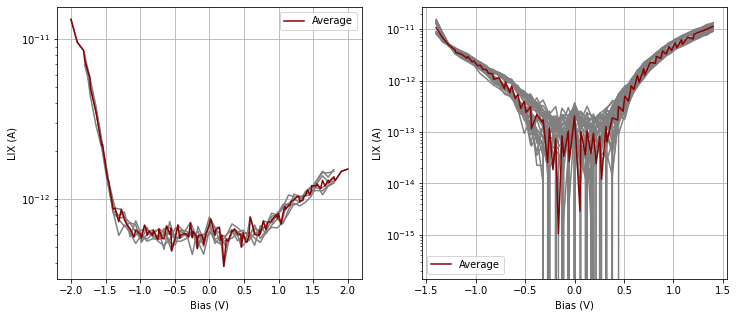

In [ ]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_yscale('log')
ax2.set_yscale('log')


n = len(data)
t1 = 6
t2 = n-2
set1 = []
set2 = []

for i, spec in enumerate(data):
    df = spec.data
    meta = spec.metadata
    bias = df['Bias calc (V)']

    if set(['Current [AVG] (A)', 'LIX 1 omega [AVG] (A)']).issubset(df.columns): 
        current = df['Current [AVG] (A)']
        dIdV = df['LIX 1 omega [AVG] (A)']
    elif set(['Current (A)', 'LIX 1 omega (A)', 'Current [bwd] (A)', 'LIX 1 omega [bwd] (A)']).issubset(df.columns):
        current_fwd = df['Current (A)']
        current_bwd = df['Current [bwd] (A)']
        current = (current_fwd + current_bwd) / 2
        dIdV_fwd = df['LIX 1 omega (A)']
        dIdV_bwd = df['LIX 1 omega [bwd] (A)']
        dIdV = (dIdV_fwd + dIdV_bwd) / 2

    # print(bias, current)
    ndc = dIdV * (bias/current)
    
    # if (current.min() > -3e-9) and (current.max() < 3e-9):
    if i < t1:
        set1.append(pd.concat([bias, dIdV, ndc.rename('NDC')], axis=1))
        ax1.plot(bias, dIdV, color='gray')
    elif i < t1 + 2:
        pass
        # set1.append(pd.concat([bias, dIdV], axis=1))
        # ax1.plot(bias, dIdV)
    elif i < t2:
        set2.append(pd.concat([bias, dIdV.rename('LIX 1 omega [AVG] (A)'), ndc.rename('NDC')], axis=1))
        ax2.plot(bias, dIdV, color='gray')
    else:
        # set2.append(pd.concat([bias, dIdV], axis=1))
        # line, = ax2.plot(bias, dIdV, color = 'red')
        # line.set_label('on bright defect')
        pass
        
# ax2.legend()
# ax1.set_ylim(bottom=1e-14, top=2e-11)
# print(set1)   
bias = data[0].data['Bias calc (V)']
set1_df = pd.concat(set1, ignore_index=True)
set1_avg_df, set1_std_df = avg_STS(set1_df, by='Bias calc (V)')

set2_df = pd.concat(set2, ignore_index=True)
set2_avg_df, set2_std_df = avg_STS(set2_df, by='Bias calc (V)')

ax1.plot(set1_avg_df['Bias calc (V)'], set1_avg_df['LIX 1 omega [AVG] (A)'], color='darkred', label='Average')
ax1.set_xlabel('Bias (V)')
ax1.set_ylabel('LIX (A)')
ax1.grid()
ax1.legend()
ax2.plot(set2_avg_df['Bias calc (V)'], set2_avg_df['LIX 1 omega [AVG] (A)'], color='darkred', label='Average')
ax2.set_xlabel('Bias (V)')
ax2.set_ylabel('LIX (A)')
ax2.grid()
ax2.legend()
plt.show()

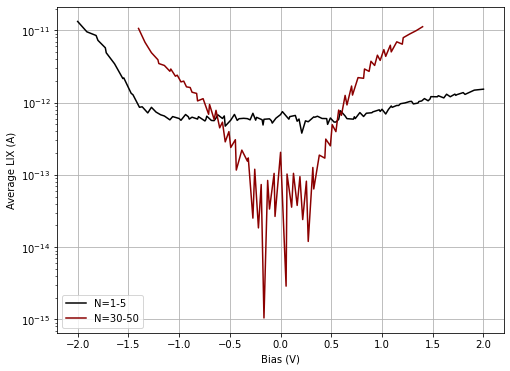

In [ ]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.set_yscale('log')
ax1.plot(set1_avg_df['Bias calc (V)'], set1_avg_df['LIX 1 omega [AVG] (A)'], color='black', label="N=1-5")
# ax1.fill_between(set1_avg_df['Bias calc (V)'],
#                              set1_avg_df['LIX 1 omega [AVG] (A)'] - set1_std_df['Bias calc (V)'],
#                              set1_avg_df['LIX 1 omega [AVG] (A)'] + set1_std_df['Bias calc (V)'],
#                              alpha=0.3,
#                              facecolor='gray',
#                              antialiased=True)
ax1.plot(set2_avg_df['Bias calc (V)'], set2_avg_df['LIX 1 omega [AVG] (A)'], color='darkred', label='N=30-50')
ax1.set_xlabel('Bias (V)')
ax1.set_ylabel('Average LIX (A)')
# ax1.set_xlim(left=-1, right=1)
ax1.grid()
plt.legend()
plt.show()


0.2652456431856434 -0.09406165975138411
[ 0.26524564 -0.09406166]


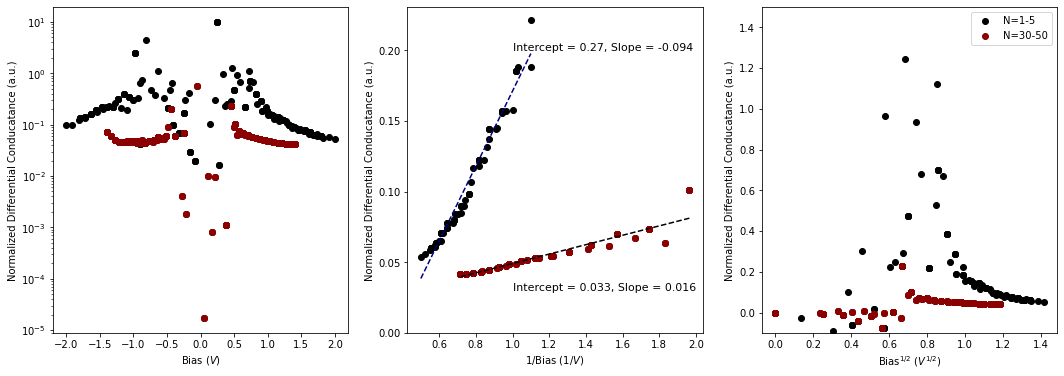

In [ ]:
from scipy.optimize import curve_fit

def linear(x, m, b):
    return m*x + b

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(131)
ax1.set_yscale('log')

bias1 = set1_avg_df['Bias calc (V)']
bias2 = set2_avg_df['Bias calc (V)']
ndc1 = set1_avg_df['NDC']
ndc2 = set2_avg_df['NDC']

ax1.scatter(bias1, ndc1, color='black', label="N=1-5")
ax1.scatter(bias2, ndc2, color='darkred', label='N=30-50')
ax1.set_xlabel('Bias ($V$)')
ax1.set_ylabel('Normalized Differential Conducatance (a.u.)')
# ax1.grid()
# ax1.set_xlim(left=-1, right=1)

x1 = 1/bias1[198:270]
x1 = x1.sort_values(ascending=True)
y1 = ndc1[198:270]
y1 = y1.sort_values(ascending=True)

param1, param_cov1 = curve_fit(linear, x1, y1)
# ans stores the new y-data according to
# the coefficients given by curve-fit() function
ans1 = param1[0]*x1 + param1[1]
print(param1[0], param1[1])

z = np.polyfit(x1, y1, 1)
p = np.poly1d(z)
print(z)

n = len(bias2) #1710
offset = 35
x2 = 1/bias2[(4*n//6) + offset:]
y2 = ndc2[(4*n//6) + offset:]
param2, param_cov2 = curve_fit(linear, x2, y2)
# ans stores the new y-data according to
# the coefficients given by curve-fit() function
ans2 = param2[0]*x2 + param2[1]


ax2 = fig.add_subplot(132)
# ax2.set_yscale('log')
ax2.scatter(x1, y1, color='black', label="N=1-5")
ax2.scatter(x2, y2, color='darkred', label='N=30-50')
ax2.plot(x1, ans1, '--', color ='navy', label ="optimized set1 data")
ax2.text(1.0, 0.2, f'Intercept = {param1[0]:.2}, Slope = {param1[1]:.2}', fontsize = 11)
ax2.plot(x2, ans2, '--', color ='black', label ="optimized set2 data")
ax2.text(1.0, 0.03, f'Intercept = {param2[0]:.2}, Slope = {param2[1]:.2}', fontsize = 11)
ax2.set_xlabel('1/Bias ($1/V$)')
ax2.set_ylabel('Normalized Differential Conducatance (a.u.)')
# ax2.set_xlim(left=0, right=4)
ax2.set_ylim(bottom=0, top=None)

ax3 = fig.add_subplot(133)
# ax3.set_yscale('log')
ax3.scatter(np.sqrt(bias1[130:270]), ndc1[130:270], color='black', label="N=1-5")
ax3.scatter(np.sqrt(bias2[(3*n//6):]), ndc2[(3*n//6):], color='darkred', label='N=30-50')
ax3.set_xlabel('Bias$^{1/2}$ ($V^{1/2}$)')
ax3.set_ylabel('Normalized Differential Conducatance (a.u.)')
# ax3.set_xlim(left=0, right=4)
ax3.set_ylim(bottom=-0.1, top=1.5)

plt.legend()
plt.show()

      Bias calc (V)  LIX 1 omega [AVG] (A)             0
0              -1.4           9.104820e-12           NaN
45             -1.4           8.387970e-12           NaN
90             -1.4           8.542520e-12           NaN
135            -1.4           8.442650e-12           NaN
180            -1.4           8.414240e-12           NaN
225            -1.4           8.389800e-12           NaN
270            -1.4           8.127240e-12           NaN
315            -1.4           8.624800e-12           NaN
360            -1.4           8.545540e-12           NaN
405            -1.4           8.800370e-12           NaN
450            -1.4           8.304120e-12           NaN
495            -1.4           8.552190e-12           NaN
540            -1.4           8.310000e-12           NaN
585            -1.4           8.166510e-12           NaN
630            -1.4           8.219870e-12           NaN
675            -1.4           8.387300e-12           NaN
720            -1.4           8

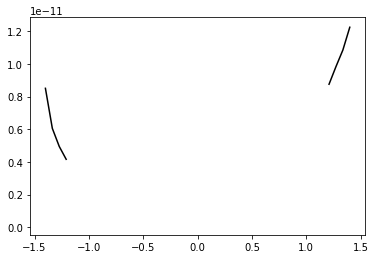

In [ ]:
by = 'Bias calc (V)'
df = set2_df
avgs = []
for bias in df[by]:
    mask = df[by] == bias
    samples = df[mask]
    print(samples)
    samples_avg = samples.mean()
    avgs.append(samples_avg)

avgs_df = pd.DataFrame(avgs)
avgs_df = avgs_df.sort_values(by=[by], ascending=True)
plt.plot(avgs_df['Bias calc (V)'], avgs_df['LIX 1 omega [AVG] (A)'], color='black')

<AxesSubplot:>

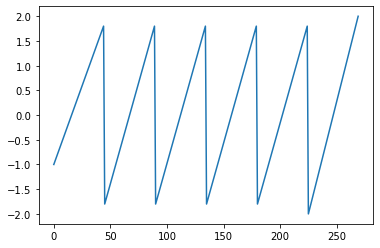

In [ ]:
set1_df['Bias calc (V)'].plot()

<AxesSubplot:>

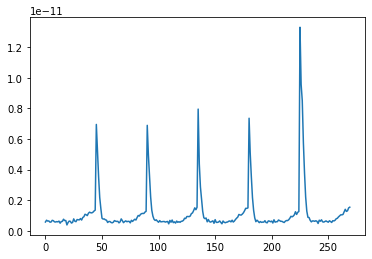

In [ ]:
set1_df['LIX 1 omega [AVG] (A)'].plot

<AxesSubplot:>

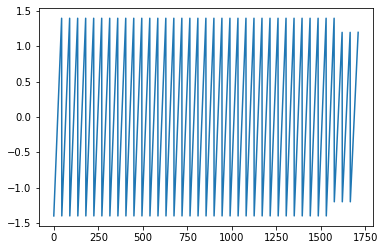

In [ ]:
set2_df['Bias calc (V)'].plot()

<AxesSubplot:>

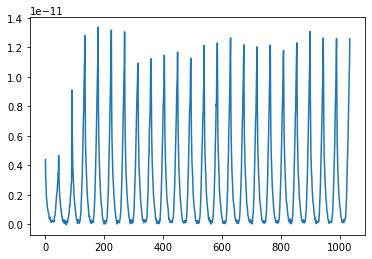

In [ ]:
set2_df['LIX 1 omega [AVG] (A)'].plot()

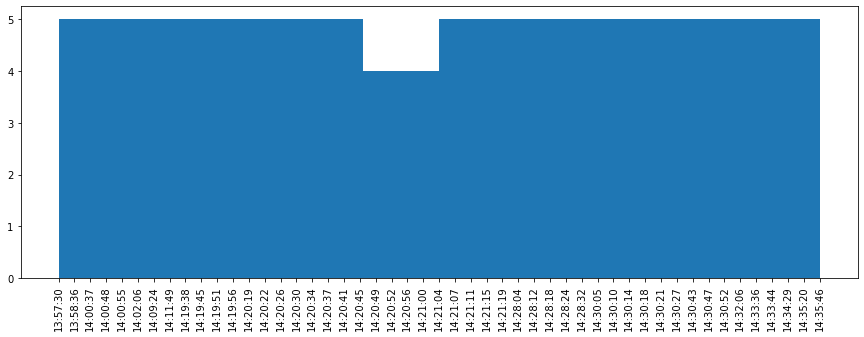

In [ ]:
from datetime import datetime

datetimes = []
for spec in data:
    df = spec.data
    meta = spec.metadata
    # print(meta)
    datetime_str = meta['Value'][0]
    x, y, z = meta['Value'][2], meta['Value'][3], meta['Value'][4]
    # print(x, y, z)
    datetime_obj = datetime.strptime(datetime_str, '%d.%m.%Y %H:%M:%S')
    datetimes.append(str(datetime_obj.time()))

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.hist(datetimes)
plt.xticks(rotation=90)
plt.show()